In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eqmarl import *
import pennylane as qml
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.optimize import minimize
from scipy.stats import wasserstein_distance
from scipy.special import kl_div

2023-12-21 11:25:49.593535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test localized versus joint measurements for Alice and Bob

In [3]:
dev = qml.device('default.qubit')

@qml.qnode(dev)
def circuit0():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    
    qml.RX(phi=np.pi/3, wires=0)
    
    return [qml.state(), qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1)), qml.expval(qml.PauliZ(wires=0) @ qml.PauliZ(wires=1))]

circuit0()

[tensor([0.61237244+0.j        , 0.        -0.35355339j,
         0.        -0.35355339j, 0.61237244+0.j        ], requires_grad=True),
 tensor(0., requires_grad=True),
 tensor(0., requires_grad=True),
 tensor(0.5, requires_grad=True)]

## Test difference between measuring $Z$ and $Z \otimes I$ and $I \otimes Z$

In [4]:
dev = qml.device('default.qubit')

@qml.qnode(dev)
def circuit1(theta):
    qml.RX(theta[0], wires=0)
    qml.RY(theta[1], wires=0)
    qml.RZ(theta[2], wires=0)
    return [qml.expval(qml.PauliZ(wires=0))]


@qml.qnode(dev)
def circuit2(theta):
    qml.RX(theta[0, 0], wires=0)
    qml.RY(theta[0, 1], wires=0)
    qml.RZ(theta[0, 2], wires=0)
    
    qml.RX(theta[1, 0], wires=1)
    qml.RY(theta[1, 1], wires=1)
    qml.RZ(theta[1, 2], wires=1)
    return [qml.expval(qml.PauliZ(wires=0)@qml.Identity(wires=1)), qml.expval(qml.Identity(wires=0) @ qml.PauliZ(wires=1))]



# circuit1([np.pi/2, np.pi/3, np.pi/4])

In [5]:
theta = np.random.uniform(0, 2*np.pi, size=(2,3))
theta

array([[3.45129917, 4.29799884, 3.01716542],
       [5.17991945, 2.00644121, 4.76073003]])

In [6]:
circuit1(theta[0]), circuit1(theta[1])

([tensor(0.38347578, requires_grad=True)],
 [tensor(-0.1901861, requires_grad=True)])

In [7]:
circuit2(theta)

[tensor(0.38347578, requires_grad=True),
 tensor(-0.1901861, requires_grad=True)]

## Matrix and function definitions

In [8]:
def expectedValueOfObservable(psi, obs):
    return np.transpose(np.conjugate(psi)) @ obs @ psi

def kron(*args):
    """Kronecker product of a list of elements."""
    return ft.reduce(np.kron, args)

In [9]:
def dagger(x):
    """Conjugate transpose."""
    return (x.conjugate()).transpose()

def closest_power_of_two(x):
    """Inspired by https://stackoverflow.com/a/14267557"""
    return 1 if x == 0 else 2**(x-1).bit_length()

def ket(*x, dim=1):
    """|x0, x1, ...>"""
    # assert all(i in (0, 1) for i in x), 'ket only accepts binary 0 or 1'
    # x = [np.array([[0], [1]]) if i else np.array([[1], [0]]) for i in x]
    # dim = 1 + int(max(np.max(x), dim))
    max_val = int(max(np.max(x), dim))
    if max_val == 1 or max_val % 2 == 0:
        dim = closest_power_of_two(max_val+1)
    else:
        dim = closest_power_of_two(max_val)
    x = np.eye(dim, dtype=int)[list(x)]
    x = x.reshape((-1, dim, 1))
    x = kron(*x)
    return x

def bra(*x):
    """<x0, x1, ...|"""
    # assert all(i in (0, 1) for i in x), 'bra only accepts binary 0 or 1'
    x = ket(*x)
    return dagger(x)

In [10]:
def bell(src=0, tgt=1, bellstate: Literal[0,1,2,3] = 0, nwires=2, op=qml.CNOT):
    """Matrix representation for circuit that creates a Bell state on the designated source and target qubits.
    
    Supply the `bellstate` argument to prepare a specific Bell state:
    - 0 == Phi+
    - 1 == Psi+
    - 2 == Phi-
    - 3 == Psi-
    
    The Bell state vector can be recovered by applying the dot product with the |0> state as follows:
    >>> U = bell(0, 1, bellstate=0, nwires=2) # Creates matrix which generates Phi+
    >>> U @ np.array([[1], [0], [0], [0]]) # Dot product with |00>
    array([[0.70710678],
       [0.        ],
       [0.        ],
       [0.70710678]])
    """
    def circuit():
        match bellstate:
            case 1: # 01
                qml.PauliX(wires=tgt)
            case 2: # 10
                qml.PauliX(wires=src)
            case 3: # 11
                qml.PauliX(wires=tgt)
                qml.PauliX(wires=src)
            case _: # 00
                pass
        qml.Hadamard(wires=src)
        op(wires=[src, tgt])
    return qml.matrix(circuit, wire_order=range(nwires))()


def ghz(src: int = 0, tgt: list[int] = 1, bellstate: Literal[0,1,2,3] = 0, nwires=2, op=qml.CNOT):
    
    if isinstance(tgt, int):
        tgt = [tgt]
    
    def circuit():
        if bellstate in (2, 3):
            qml.PauliX(wires=src)
        qml.Hadamard(wires=src)
        for t in tgt:
            if bellstate in (1, 3):
                qml.PauliX(wires=t)
            op(wires=[src, t])
    return qml.matrix(circuit, wire_order=range(nwires))()


In [11]:
# Get matrix representations of Pauli operators and other common gates.
X = qml.matrix(qml.PauliX(wires=0))
Y = qml.matrix(qml.PauliY(wires=0))
Z = qml.matrix(qml.PauliZ(wires=0))
H = qml.matrix(qml.Hadamard(wires=0))
I = qml.matrix(qml.Identity(wires=0))
CNOT = lambda src=0, tgt=1, nwires=2: qml.matrix(qml.CNOT(wires=[src, tgt]), wire_order=range(nwires)) # CNOT(source, target, number_of_wires)
CZ = lambda src=0, tgt=1, nwires=2: qml.matrix(qml.CZ(wires=[src, tgt]), wire_order=range(nwires)) # CZ(source, target, number_of_wires)

In [12]:
# Matrices that create specific bell states on 2 qubits next-neighbor style (source is qubit 0, target is qubit 1).
bell_phi_plus = bell(src=0, tgt=1, bellstate=0, nwires=2)
bell_psi_plus = bell(src=0, tgt=1, bellstate=1, nwires=2)
bell_phi_minus = bell(src=0, tgt=1, bellstate=2, nwires=2)
bell_psi_minus = bell(src=0, tgt=1, bellstate=3, nwires=2)

In [13]:
O = np.array([
    [
        kron(Z, I, I, I),
        kron(Z, I, Z, I),
    ],
    [
        kron(Z, Z, I, I),
        kron(I, I, Z, Z),
    ],
])

np.all((O[0][0] @ O[0][1]) == (O[0][1] @ O[0][0]))
np.all((O[1][0] @ O[1][1]) == (O[1][1] @ O[1][0]))

True

In [14]:
# O = kron(Z, I)
# O = kron(I, Z)
O = kron(Z, Z)
s = bell_phi_plus@ket(0,0)

expectedValueOfObservable(s, O)

array([[1.]])

In [15]:
O = Z

# s = H @ ket(0)
s = ket(1)

expectedValueOfObservable(s, O)

array([[-1]])

In [16]:
ket(0,0,0,0)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

## Circuit Tests

### 2 Agents

In [17]:
n_agents = 2
d_qubits = 2
n_layers = 1

circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

weight_shapes = circuit.weight_shapes

agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

print(qml.draw(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs))


# System unitary (all agents).
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)

0: ─╭VariationalEncodingPQC─┤  
1: ─╰VariationalEncodingPQC─┤  
2: ─╭VariationalEncodingPQC─┤  
3: ─╰VariationalEncodingPQC─┤  


In [18]:
obs = [
    kron(Z, I, I, I),
    kron(I, Z, I, I),
    kron(Z, Z, I, I),
    
    # kron(Z, I, Z, I),
    # kron(I, Z, I, Z),
    # kron(Z, Z, Z, Z),
    #
    kron(I, I, Z, I),
    kron(I, I, I, Z),
    kron(I, I, Z, Z),
    
    # kron(Z, I, Z, I),
    # kron(I, Z, I, Z),
    # kron(Z, Z, Z, Z),
    ]
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

In [19]:
np.all((kron(Z, Z, Z, Z) @ kron(I, Z, I, Z) @ kron(Z, I, Z, I)) == (kron(Z, I, Z, I) @ kron(I, Z, I, Z) @ kron(Z, Z, Z, Z)))

True

In [20]:
O1 = qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=2) @ qml.PauliZ(wires=3)
O2 = qml.PauliZ(wires=1) @ qml.PauliZ(wires=3)

qml.matrix(O1 @ O2)

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/operation.py:2218: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/operation.py:2366: UserWarning: The size of the returned matrix (64) will not be compatible with the subspace of the wires of the Tensor (16). This likely is due to wires being used in multiple tensor product factors of the Tensor.
  warnings.warn(


array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       [ 0,  0, -1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., -1,  0,  0],
       [ 0,  0,  0, ...,  0, -1,  0],
       [ 0,  0,  0, ...,  0,  0,  1]])

In [21]:
obs = [
    # agent 1
    kron(Z, I, I, I),
    kron(I, Z, I, I),
    kron(Z, Z, I, I),
    # agent 2
    kron(I, I, Z, I),
    kron(I, I, I, Z),
    kron(I, I, Z, Z),
    # together
    kron(Z, I, Z, I),
    kron(I, Z, I, Z),
    kron(Z, Z, Z, Z),
    
    # kron(X, I, X, I),
    # kron(I, X, I, X),
    # kron(X, X, X, X),
    # kron(Y, I, Y, I),
    # kron(I, Y, I, Y),
    # kron(Y, Y, Y, Y),
    ]
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

B = bell(src=0, tgt=2, bellstate=0, nwires=4) @ bell(src=1, tgt=3, bellstate=0, nwires=4) # Phi+ on [0,2] and [1,3]

M = (U @ B) @ ket(0,0,0,0)
# M = U @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# # Difference between agent observables.
# diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, E[-3:], softmax(E[-3:].flatten())

(array([[[-2.77555756e-17+0.j]],
 
        [[ 1.38777878e-17+0.j]],
 
        [[ 2.77555756e-16+0.j]],
 
        [[ 8.32667268e-17+0.j]],
 
        [[-2.77555756e-17+0.j]],
 
        [[ 2.49800181e-16+0.j]],
 
        [[-6.87358958e-01+0.j]],
 
        [[-3.96683792e-01+0.j]],
 
        [[ 3.02616612e-01+0.j]]]),
 array([[[-0.68735896+0.j]],
 
        [[-0.39668379+0.j]],
 
        [[ 0.30261661+0.j]]]),
 array([0.19886651+0.j, 0.26595017+0.j, 0.53518333+0.j]))

In [27]:
n_agents = 2
d_qubits = 4
n_layers = 5

circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

weight_shapes = circuit.weight_shapes

agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

print(qml.draw(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs))


# System unitary (all agents).
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)

0: ─╭VariationalEncodingPQC─┤  
1: ─├VariationalEncodingPQC─┤  
2: ─├VariationalEncodingPQC─┤  
3: ─╰VariationalEncodingPQC─┤  
4: ─╭VariationalEncodingPQC─┤  
5: ─├VariationalEncodingPQC─┤  
6: ─├VariationalEncodingPQC─┤  
7: ─╰VariationalEncodingPQC─┤  


In [34]:
obs = [
    # # agent 1
    # kron(Z, I, I, I),
    # kron(I, Z, I, I),
    # kron(Z, Z, I, I),
    # # agent 2
    # kron(I, I, Z, I),
    # kron(I, I, I, Z),
    # kron(I, I, Z, Z),
    # together
    kron(Z, I, Z, I    , Z, I, Z, I),
    kron(I, Z, I, Z    , I, Z, I, Z),
    kron(Z, Z, Z, Z    , Z, Z, Z, Z),
    # kron(Z, Z, Z, Z    , Z, Z, Z, Z),
    
    # kron(X, I, X, I),
    # kron(I, X, I, X),
    # kron(X, X, X, X),
    # kron(Y, I, Y, I),
    # kron(I, Y, I, Y),
    # kron(Y, Y, Y, Y),
    ]
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

# 0 1 2 3
# 4 5 6 7
bellstate = 0
B = bell(src=0, tgt=4, bellstate=bellstate, nwires=8) \
    @ bell(src=1, tgt=5, bellstate=bellstate, nwires=8) \
        @ bell(src=2, tgt=6, bellstate=bellstate, nwires=8) \
            @ bell(src=3, tgt=7, bellstate=bellstate, nwires=8) # Phi+ across agent qubits.

M = (U @ B) @ ket(0,0,0,0,0,0,0,0)
# M = U @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E_joint = expectedValueOfObservable(M, obs).flatten()
E_joint = np.abs(E_joint) # Magnitude of complex expected values.
E_joint_softmax = softmax(E_joint)

E_joint_scaled = (1+E_joint)/2.
E_joint_scaled_softmax = softmax(E_joint_scaled)

# # Difference between agent observables.
# diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])


print(f"{E_joint=}")
print(f"{E_joint_softmax=}")
print(f"{E_joint_scaled=}")
print(f"{E_joint_scaled_softmax=}")

E_joint=array([0.10103684, 0.11110682, 0.15932905])
E_joint_softmax=array([0.32571746, 0.32901399, 0.34526855])
E_joint_scaled=array([0.55051842, 0.55555341, 0.57966452])
E_joint_scaled_softmax=array([0.32953026, 0.33119362, 0.33927612])


In [29]:
obs = [
    # # agent 1
    # kron(Z, I, I, I),
    # kron(I, Z, I, I),
    # kron(Z, Z, I, I),
    # # agent 2
    # kron(I, I, Z, I),
    # kron(I, I, I, Z),
    # kron(I, I, Z, Z),
    # together
    kron(Z, I, Z, I    , I, I, I, I),
    kron(I, I, I, I    , Z, I, Z, I),
    
    kron(I, Z, I, Z    , I, I, I, I),
    kron(I, I, I, I    , I, Z, I, Z),
    
    kron(Z, Z, Z, Z    , I, I, I, I),
    kron(I, I, I, I    , Z, Z, Z, Z),
    # kron(Z, Z, Z, Z    , Z, Z, Z, Z),
    
    # kron(X, I, X, I),
    # kron(I, X, I, X),
    # kron(X, X, X, X),
    # kron(Y, I, Y, I),
    # kron(I, Y, I, Y),
    # kron(Y, Y, Y, Y),
    ]
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

M = U @ ket(0,0,0,0,0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E_local = expectedValueOfObservable(M, obs).reshape((2,3))
E_local = np.abs(E_local) # Magnitude of complex expected values.
E_local_softmax = softmax(E_local, axis=1)
E_local_scaled = (1+E_local)/2.
E_local_scaled_softmax = softmax(E_local_scaled, axis=1)

# # Difference between agent observables.
# diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

# E_local, E_local_softmax, E_local_scaled, E_local_scaled_softmax
print(f"{E_local=}")
print(f"{E_local_softmax=}")
print(f"{E_local_scaled=}")
print(f"{E_local_scaled_softmax=}")

E_local=array([[0.17488355, 0.37106746, 0.01710815],
       [0.23575388, 0.06663942, 0.12137374]])
E_local_softmax=array([[0.32564886, 0.39623347, 0.27811767],
       [0.36545285, 0.30859286, 0.32595428]])
E_local_scaled=array([[0.58744177, 0.68553373, 0.50855407],
       [0.61787694, 0.53331971, 0.56068687]])
E_local_scaled_softmax=array([[0.3303374 , 0.36438337, 0.30527923],
       [0.34924327, 0.3209263 , 0.32983043]])


In [107]:
wasserstein_distance(E_local_scaled_softmax[0,:], E_joint_scaled_softmax)

0.010318939608249275

In [108]:
wasserstein_distance(E_local_scaled_softmax[1,:], E_joint_scaled_softmax)

0.009793067411278222

In [109]:
kl_div(E_local_scaled_softmax[0,:], E_joint_scaled_softmax)

array([3.41635671e-04, 3.25627366e-04, 2.00100229e-06])

In [110]:
kl_div(E_local_scaled_softmax[1,:], E_joint_scaled_softmax)

array([0.00030175, 0.00245691, 0.00104592])

In [69]:
np.all((kron(Z, X, Y) @ kron(X, Z, Y)) == (kron(X, Z, Y) @ kron(Z, X, Y)))

True

#### Minimization using Scipy

In [20]:
def min_func(psi, agents_var_thetas, agents_enc_inputs):
    # minimize the sum of absolute differences between expected values of observables.

    U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)
    
    state = U @ psi.reshape((16,1))
    
    E = expectedValueOfObservable(state, obs)
    E = np.reshape(E, (2, 3))
    
    # print(np.abs(E))
    print(E.shape)
    dist = softmax(E, axis=1) # Estimate probability distribution of expected values of observables.
    
    # diffs = np.array([np.abs(E[i]-E[i+n_obs_per_agent]) for i in range(n_obs_per_agent)]) # Match the expected values.
    diffs = np.array([np.abs(dist[0][i]-dist[1][i]) for i in range(n_obs_per_agent)]) # Match the distributions.
    print(dist)
    sum_diffs = np.sum(diffs)
    return sum_diffs

def norm_constraint(psi):
    # return 1. - np.abs(psi)**2.
    return 1. - np.linalg.norm(psi)



agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

psi_0 = ket(0,0,0,0).flatten()

cons = {'type': 'eq', 'fun': norm_constraint}

res = minimize(
    fun=lambda psi: min_func(psi, agents_var_thetas, agents_enc_inputs),
    x0=psi_0,
    method='trust-constr',
    constraints=cons,
    )
res

(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578604+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.6562068 +0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620678+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.1963478 +0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634781+0.j 0.1474454 +0.j 0.65620679+0.j]]
(2, 3)
[[0.52578603+0.j 0.24387742+0.j 0.23033655+0.j]
 [0.19634

(2, 3)
[[0.44528343+0.j 0.24208434+0.j 0.31263223+0.j]
 [0.33885343+0.j 0.17920357+0.j 0.481943  +0.j]]
(2, 3)
[[0.44528343+0.j 0.24208434+0.j 0.31263223+0.j]
 [0.33885343+0.j 0.17920357+0.j 0.481943  +0.j]]
(2, 3)
[[0.44528342+0.j 0.24208434+0.j 0.31263224+0.j]
 [0.33885343+0.j 0.17920357+0.j 0.481943  +0.j]]
(2, 3)
[[0.44528343+0.j 0.24208434+0.j 0.31263223+0.j]
 [0.33885343+0.j 0.17920357+0.j 0.481943  +0.j]]
(2, 3)
[[0.44528343+0.j 0.24208434+0.j 0.31263223+0.j]
 [0.33885343+0.j 0.17920357+0.j 0.481943  +0.j]]
(2, 3)
[[0.44528343+0.j 0.24208434+0.j 0.31263223+0.j]
 [0.33885343+0.j 0.17920357+0.j 0.481943  +0.j]]
(2, 3)
[[0.42885446+0.j 0.23830139+0.j 0.33284414+0.j]
 [0.3797331 +0.j 0.19067787+0.j 0.42958902+0.j]]
(2, 3)
[[0.42885447+0.j 0.23830139+0.j 0.33284414+0.j]
 [0.3797331 +0.j 0.19067787+0.j 0.42958903+0.j]]
(2, 3)
[[0.42885447+0.j 0.23830139+0.j 0.33284414+0.j]
 [0.3797331 +0.j 0.19067787+0.j 0.42958902+0.j]]
(2, 3)
[[0.42885447+0.j 0.23830139+0.j 0.33284414+0.j]
 [0.37973

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


(2, 3)
[[0.42908897+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908897+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908896+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908896+0.j 0.21468992+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908896+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908897+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908896+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908896+0.j 0.21468993+0.j 0.35622112+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908897+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908908+0.j 0.21468992+0.j 0.356221  +0.j]]
(2, 3)
[[0.42908897+0.j 0.21468993+0.j 0.35622111+0.j]
 [0.42908

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 3.4773988966119163e-09
                x: [ 8.077e-01  2.553e-01 ... -8.852e-02  6.269e-03]
              nit: 70
             nfev: 1751
             njev: 103
             nhev: 0
         cg_niter: 95
     cg_stop_cond: 2
             grad: [ 1.752e-01  1.223e-01 ... -7.610e-02 -1.822e-01]
  lagrangian_grad: [-4.552e-01 -7.690e-02 ... -7.026e-03 -1.871e-01]
           constr: [array([ 0.000e+00])]
              jac: [array([[-8.077e-01, -2.553e-01, ...,  8.852e-02,
                           -6.269e-03]])]
      constr_nfev: [1751]
      constr_njev: [0]
      constr_nhev: [0]
                v: [array([ 7.804e-01])]
           method: equality_constrained_sqp
       optimality: 0.7056918995606642
 constr_violation: 0.0
   execution_time: 16.298287868499756
        tr_radius: 9.692809848209433e-09
   constr_penalty: 1.0
            niter: 70

In [21]:
res.x, np.linalg.norm(res.x), 

(array([ 0.80773347,  0.25530578, -0.36270836,  0.17341882, -0.06780391,
         0.01435954, -0.0510092 ,  0.00964018, -0.18523506, -0.03344022,
         0.03670996, -0.02282722, -0.2607602 ,  0.00930838, -0.08851502,
         0.00626862]),
 1.0)

In [22]:
# Same parameters, same env state
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)
state = U @ res.x.reshape((16,1))
E = expectedValueOfObservable(state, obs)
E = E.reshape((2,3))
E, softmax(E, axis=1)

(array([[-0.00576139+0.j, -0.69823091+0.j, -0.19187415+0.j],
        [ 0.02832813+0.j, -0.66414139+0.j, -0.15778463+0.j]]),
 array([[0.42908898+0.j, 0.21468993+0.j, 0.35622109+0.j],
        [0.42908899+0.j, 0.21468993+0.j, 0.35622108+0.j]]))

In [23]:
# Same parameters, random env state.
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs']))
state = U @ res.x.reshape((16,1))
E = expectedValueOfObservable(state, obs)
E = E.reshape((2,3))
E, softmax(E, axis=1)

(array([[-0.44851887+0.j, -0.67242362+0.j,  0.36634575+0.j],
        [-0.09208074+0.j, -0.42803641+0.j,  0.57496794+0.j]]),
 array([[0.24641095+0.j, 0.19697877+0.j, 0.55661028+0.j],
        [0.27299036+0.j, 0.19509387+0.j, 0.53191577+0.j]]))

In [24]:
np.outer(res.x, res.x.conj())

array([[ 6.52433366e-01,  2.06219025e-01, -2.92971684e-01,
         1.40076183e-01, -5.47674896e-02,  1.15986831e-02,
        -4.12018409e-02,  7.78669968e-03, -1.49620558e-01,
        -2.70107883e-02,  2.96518647e-02, -1.84383118e-02,
        -2.10624745e-01,  7.51868896e-03, -7.14965476e-02,
         5.06337358e-03],
       [ 2.06219025e-01,  6.51810415e-02, -9.26015409e-02,
         4.42748263e-02, -1.73107307e-02,  3.66607420e-03,
        -1.30229444e-02,  2.46119481e-03, -4.72915814e-02,
        -8.53748247e-03,  9.37226536e-03, -5.82792189e-03,
        -6.65735872e-02,  2.37648285e-03, -2.25983972e-02,
         1.60041472e-03],
       [-2.92971684e-01, -9.26015409e-02,  1.31557354e-01,
        -6.29004546e-02,  2.45930458e-02, -5.20832611e-03,
         1.85014645e-02, -3.49657549e-03,  6.71863046e-02,
         1.21290488e-02, -1.33150099e-02,  8.27962448e-03,
         9.45799057e-02, -3.37622673e-03,  3.21051391e-02,
        -2.27368060e-03],
       [ 1.40076183e-01,  4.42748263e

In [25]:
np.all(qml.math.dm_from_state_vector(res.x) == np.outer(res.x, res.x.conj()))

True

In [26]:
n_agents, d_qubits

(2, 2)

In [27]:
state = 1/np.sqrt(2) * (ket(0, qubits=4) + ket(15, qubits=4))

TypeError: ket() got an unexpected keyword argument 'qubits'

In [ ]:
rho = qml.math.dm_from_state_vector(res.x)
qml.math.vn_entropy(rho, indices=[0,1], base=2)

0.07949420158401875

In [ ]:
min_func(res.x, agents_var_thetas, agents_enc_inputs)

1.3167849018114186e-07

In [ ]:
# Now try using random encoder inputs (simulates a random environment state).
min_func(res.x, agents_var_thetas, np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs']))

2.4671554787637007

In [ ]:
psi_0.shape

(16, 1)

#### Resume before minimization

In [ ]:
###############
# Make a guess for the system unitary.
agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)



###############

In [ ]:
M = U @ ket(0,0,0,0) # |0> initial state

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[ 0.57591135+0.j]],
 
        [[-0.23505438+0.j]],
 
        [[-0.23967556+0.j]],
 
        [[-0.81992053+0.j]],
 
        [[-0.28459579+0.j]],
 
        [[ 0.17702326+0.j]]]),
 array([[[ 1.39583188+0.j]],
 
        [[ 0.04954141+0.j]],
 
        [[-0.41669882+0.j]]]))

In [ ]:
B = kron(bell_phi_plus, bell_phi_plus) # Phi+ on [0,1] and [2,3]
M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[-0.2319347 +0.j]],
 
        [[ 0.34450437+0.j]],
 
        [[ 0.14770661+0.j]],
 
        [[ 0.13816775+0.j]],
 
        [[-0.15996256+0.j]],
 
        [[ 0.30900636+0.j]]]),
 array([[[-0.37010246+0.j]],
 
        [[ 0.50446694+0.j]],
 
        [[-0.16129975+0.j]]]))

In [28]:
B = bell(src=0, tgt=2, bellstate=0, nwires=4) @ bell(src=1, tgt=3, bellstate=0, nwires=4) # Phi+ on [0,2] and [1,3]

M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[-1.11022302e-16+0.j]],
 
        [[-5.55111512e-17+0.j]],
 
        [[ 1.11022302e-16+0.j]],
 
        [[-5.96091429e-01+0.j]],
 
        [[-5.08412773e-01+0.j]],
 
        [[ 6.44779736e-01+0.j]],
 
        [[-1.38777878e-17+0.j]],
 
        [[ 1.66533454e-16+0.j]],
 
        [[ 5.55111512e-17+0.j]],
 
        [[-5.96091429e-01+0.j]],
 
        [[-5.08412773e-01+0.j]],
 
        [[ 6.44779736e-01+0.j]]]),
 array([[[-9.71445147e-17+0.j]],
 
        [[-2.22044605e-16+0.j]],
 
        [[ 5.55111512e-17+0.j]],
 
        [[ 0.00000000e+00+0.j]],
 
        [[ 0.00000000e+00+0.j]],
 
        [[ 0.00000000e+00+0.j]]]))

In [16]:
B = ghz(src=0, tgt=[1,2,3], bellstate=0, nwires=4)
M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[ 0.53960235+0.j]],
 
        [[-0.02420637+0.j]],
 
        [[-0.07486687+0.j]],
 
        [[-0.05662746+0.j]],
 
        [[-0.02072685+0.j]],
 
        [[-0.05986937+0.j]]]),
 array([[[ 0.59622981+0.j]],
 
        [[-0.00347952+0.j]],
 
        [[-0.0149975 +0.j]]]))

In [17]:
B = ghz(src=2, tgt=[0,1,3], bellstate=3, nwires=4)
M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[ 0.53960235+0.j]],
 
        [[-0.02420637+0.j]],
 
        [[-0.07486687+0.j]],
 
        [[ 0.05662746+0.j]],
 
        [[ 0.02072685+0.j]],
 
        [[ 0.05986937+0.j]]]),
 array([[[ 0.48297489+0.j]],
 
        [[-0.04493323+0.j]],
 
        [[-0.13473624+0.j]]]))

In [18]:
B = kron(bell(src=0, tgt=1, bellstate=0, nwires=2, op=qml.CZ), bell(src=0, tgt=1, bellstate=0, nwires=2, op=qml.CZ)) # Bell0 using CZ on [0,1] and [2,3]

M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[ 0.02868017+0.j]],
 
        [[ 0.16849661+0.j]],
 
        [[-0.00969959+0.j]],
 
        [[-0.41763158+0.j]],
 
        [[ 0.81833352+0.j]],
 
        [[-0.29108864+0.j]]]),
 array([[[ 0.44631175+0.j]],
 
        [[-0.6498369 +0.j]],
 
        [[ 0.28138905+0.j]]]))

In [19]:
B = bell(src=0, tgt=2, bellstate=0, nwires=4, op=qml.CZ) @ bell(src=1, tgt=3, bellstate=0, nwires=4, op=qml.CZ) # Bell0 using CZ on [0,2] and [1,3]

M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([[[ 0.02066119+0.j]],
 
        [[ 0.98416679+0.j]],
 
        [[ 0.02249712+0.j]],
 
        [[-0.04611884+0.j]],
 
        [[-0.01410682+0.j]],
 
        [[-0.57803446+0.j]]]),
 array([[[0.06678003+0.j]],
 
        [[0.9982736 +0.j]],
 
        [[0.60053158+0.j]]]))

In [20]:
eig_vals, eig_vects = cirq.unitary_eig(U)

In [21]:
B = eig_vects[:,0]

M = (U @ B)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([ 0.15320055+0.j,  0.73044966+0.j,  0.0634686 +0.j,  0.14960812+0.j,
        -0.10223067+0.j,  0.29911848+0.j]),
 array([ 0.00359243+0.j,  0.83268033+0.j, -0.23564988+0.j]))

In [22]:
B = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

M = (U @ B)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([ 0.00754004+0.j,  0.3281781 +0.j, -0.05460231+0.j,  0.02643524+0.j,
        -0.08119637+0.j, -0.22663555+0.j]),
 array([-0.0188952 +0.j,  0.40937447+0.j,  0.17203323+0.j]))

In [23]:
B = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1)

M = (U @ B)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

E, diffs

(array([-0.06081745+0.j, -0.05733865+0.j,  0.09233038+0.j, -0.14839405+0.j,
        -0.17701397+0.j,  0.41412872+0.j]),
 array([ 0.0875766 +0.j,  0.11967532+0.j, -0.32179834+0.j]))

#### Try more than 1 layer using more complex observations.

In [62]:
names, obs = zip(*[
    # Agent 1 observations
    ## Z
    ('Z @ I @ I @ I', kron(Z, I, I, I)),
    ('I @ Z @ I @ I', kron(I, Z, I, I)),
    ('Z @ Z @ I @ I', kron(Z, Z, I, I)),
    ## X
    ('X @ I @ I @ I', kron(X, I, I, I)),
    ('I @ X @ I @ I', kron(I, X, I, I)),
    ('X @ X @ I @ I', kron(X, X, I, I)),
    ## Y
    ('Y @ I @ I @ I', kron(Y, I, I, I)),
    ('I @ Y @ I @ I', kron(I, Y, I, I)),
    ('Y @ Y @ I @ I', kron(Y, Y, I, I)),
    ## Z*
    ('Z @ X @ I @ I', kron(Z, X, I, I)),
    ('Z @ Y @ I @ I', kron(Z, Y, I, I)),
    ## X*
    ('X @ Y @ I @ I', kron(X, Y, I, I)),
    ('X @ Z @ I @ I', kron(X, Z, I, I)),
    ## Y*
    ('Y @ X @ I @ I', kron(Y, X, I, I)),
    ('Y @ Z @ I @ I', kron(Y, Z, I, I)),
    # ----
    # Agent 2 observations
    ## Z
    ('I @ I @ Z @ I', kron(I, I, Z, I)),
    ('I @ I @ I @ Z', kron(I, I, I, Z)),
    ('I @ I @ Z @ Z', kron(I, I, Z, Z)),
    ## X
    ('I @ I @ X @ I', kron(I, I, X, I)),
    ('I @ I @ I @ X', kron(I, I, I, X)),
    ('I @ I @ X @ X', kron(I, I, X, X)),
    ## Y
    ('I @ I @ Y @ I', kron(I, I, Y, I)),
    ('I @ I @ I @ Y', kron(I, I, I, Y)),
    ('I @ I @ Y @ Y', kron(I, I, Y, Y)),
    ## Z*
    ('I @ I @ Z @ X', kron(I, I, Z, X)),
    ('I @ I @ Z @ Y', kron(I, I, Z, Y)),
    ## X*
    ('I @ I @ X @ Y', kron(I, I, X, Y)),
    ('I @ I @ X @ Z', kron(I, I, X, Z)),
    ## Y*
    ('I @ I @ Y @ X', kron(I, I, Y, X)),
    ('I @ I @ Y @ Z', kron(I, I, Y, Z)),
])
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

n_agents = 2
d_qubits = 2
n_layers = 5

circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

weight_shapes = circuit.weight_shapes

agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

print(qml.draw(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs))


# System unitary (all agents).
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)


B = bell(src=0, tgt=2, bellstate=0, nwires=4) @ bell(src=1, tgt=3, bellstate=0, nwires=4) # Phi+ on [0,2] and [1,3]

M = (U @ B) @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)
E = E.flatten()

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

# Check if all expected values are near zero.
print(f"{np.all(np.abs(E) < 1e-10)=}")

# Check if all expected values are close to each other.
print(f"{np.all(np.isclose(E, E[0]))=}")

# Count number of expected values that are near zero.
print(f"{np.count_nonzero(np.abs(E) < 1e-10)=}")

# Compute each agent's observables.
E_agent0 = E[:n_obs_per_agent]
E_agent1 = E[n_obs_per_agent:]
print(f"{np.allclose(E_agent0, E_agent1)=}")
print(f"{np.allclose(np.sign(np.abs(E_agent0)), np.sign(np.abs(E_agent1)))=}")
pprint(list(zip(np.abs(E_agent0), np.abs(E_agent1))))

for i in range(len(names)):
    print(f"{names[i]}:\t{E[i]}")

0: ─╭VariationalEncodingPQC─┤  
1: ─╰VariationalEncodingPQC─┤  
2: ─╭VariationalEncodingPQC─┤  
3: ─╰VariationalEncodingPQC─┤  
np.all(np.abs(E) < 1e-10)=True
np.all(np.isclose(E, E[0]))=True
np.count_nonzero(np.abs(E) < 1e-10)=30
np.allclose(E_agent0, E_agent1)=True
np.allclose(np.sign(np.abs(E_agent0)), np.sign(np.abs(E_agent1)))=True
[(6.938893903907228e-18, 4.163336342344337e-17),
 (2.7755575615628914e-17, 3.885780586188048e-16),
 (4.440892098500626e-16, 3.885780586188048e-16),
 (5.553824967135427e-17, 8.326672684688674e-17),
 (2.0816681711721685e-16, 8.326672684688674e-17),
 (2.2898349882893854e-16, 2.0816681711721685e-16),
 (9.022155737465232e-17, 2.7755575615628914e-17),
 (1.6653345369377348e-16, 1.1102230246251565e-16),
 (9.71445146547012e-17, 1.249000902703301e-16),
 (4.163336342344337e-17, 1.6653345369377348e-16),
 (1.1102230246251565e-16, 2.393918396847994e-16),
 (1.3877787807814457e-16, 1.734723475976807e-16),
 (1.942890293094024e-16, 5.551115123125783e-17),
 (2.22071708325

In [57]:
np.sign(E_agent0), np.sum(np.sign(E_agent0))
# g0 = np.random.default_rng(seed=int(np.abs(np.sum(np.sign(E_agent0)))))
# g0 = np.random

# np.abs(E_agent0), np.abs(E_agent1)
# np.sum(np.sign(E_agent0)), np.sum(np.sign(E_agent1))

(array([ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  0.+0.j,  1.+0.j, -1.+0.j,
         1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j,
        -1.+0.j]),
 (2+0j))

In [63]:
np.abs(E_agent0)

array([6.93889390e-18, 2.77555756e-17, 4.44089210e-16, 5.55382497e-17,
       2.08166817e-16, 2.28983499e-16, 9.02215574e-17, 1.66533454e-16,
       9.71445147e-17, 4.16333634e-17, 1.11022302e-16, 1.38777878e-16,
       1.94289029e-16, 2.22071708e-16, 3.51473612e-17])

In [64]:
np.abs(E_agent1)

array([4.16333634e-17, 3.88578059e-16, 3.88578059e-16, 8.32667268e-17,
       8.32667268e-17, 2.08166817e-16, 2.77555756e-17, 1.11022302e-16,
       1.24900090e-16, 1.66533454e-16, 2.39391840e-16, 1.73472348e-16,
       5.55111512e-17, 2.77555756e-17, 2.77555756e-17])

In [84]:
names, obs = zip(*[
    # Agent 1 observations
    ## Z
    ('Z @ I @ I @ I', kron(Z, I, I, I)),
    ('I @ Z @ I @ I', kron(I, Z, I, I)),
    ('Z @ Z @ I @ I', kron(Z, Z, I, I)),
    ## X
    ('X @ I @ I @ I', kron(X, I, I, I)),
    ('I @ X @ I @ I', kron(I, X, I, I)),
    ('X @ X @ I @ I', kron(X, X, I, I)),
    ## Y
    ('Y @ I @ I @ I', kron(Y, I, I, I)),
    ('I @ Y @ I @ I', kron(I, Y, I, I)),
    ('Y @ Y @ I @ I', kron(Y, Y, I, I)),
    ## Z*
    ('Z @ X @ I @ I', kron(Z, X, I, I)),
    ('Z @ Y @ I @ I', kron(Z, Y, I, I)),
    ## X*
    ('X @ Y @ I @ I', kron(X, Y, I, I)),
    ('X @ Z @ I @ I', kron(X, Z, I, I)),
    ## Y*
    ('Y @ X @ I @ I', kron(Y, X, I, I)),
    ('Y @ Z @ I @ I', kron(Y, Z, I, I)),
    # ----
    # Agent 2 observations
    ## Z
    ('I @ I @ Z @ I', kron(I, I, Z, I)),
    ('I @ I @ I @ Z', kron(I, I, I, Z)),
    ('I @ I @ Z @ Z', kron(I, I, Z, Z)),
    ## X
    ('I @ I @ X @ I', kron(I, I, X, I)),
    ('I @ I @ I @ X', kron(I, I, I, X)),
    ('I @ I @ X @ X', kron(I, I, X, X)),
    ## Y
    ('I @ I @ Y @ I', kron(I, I, Y, I)),
    ('I @ I @ I @ Y', kron(I, I, I, Y)),
    ('I @ I @ Y @ Y', kron(I, I, Y, Y)),
    ## Z*
    ('I @ I @ Z @ X', kron(I, I, Z, X)),
    ('I @ I @ Z @ Y', kron(I, I, Z, Y)),
    ## X*
    ('I @ I @ X @ Y', kron(I, I, X, Y)),
    ('I @ I @ X @ Z', kron(I, I, X, Z)),
    ## Y*
    ('I @ I @ Y @ X', kron(I, I, Y, X)),
    ('I @ I @ Y @ Z', kron(I, I, Y, Z)),
])
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

n_agents = 2
d_qubits = 2
n_layers = 5

circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

weight_shapes = circuit.weight_shapes

agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

print(qml.draw(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs))


# System unitary (all agents).
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)


# B = bell(src=0, tgt=2, bellstate=0, nwires=4) @ bell(src=1, tgt=3, bellstate=0, nwires=4) # Phi+ on [0,2] and [1,3]

M = U @ ket(0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)
E = E.flatten()

# Difference between agent observables.
diffs = np.array([E[i]-E[i+n_obs_per_agent] for i in range(n_obs_per_agent)])

# Check if all expected values are near zero.
print(f"{np.all(np.abs(E) < 1e-10)=}")

# Check if all expected values are close to each other.
print(f"{np.all(np.isclose(E, E[0]))=}")

# Count number of expected values that are near zero.
print(f"{np.count_nonzero(np.abs(E) < 1e-10)=}")

# Compute each agent's observables.
E_agent0 = E[:n_obs_per_agent]
E_agent1 = E[n_obs_per_agent:]
print(f"{np.allclose(E_agent0, E_agent1)=}")
print(f"{np.allclose(np.sign(E_agent0), np.sign(E_agent1))=}")

for i in range(len(names)):
    print(f"{names[i]}:\t{E[i]}")

0: ─╭VariationalEncodingPQC─┤  
1: ─╰VariationalEncodingPQC─┤  
2: ─╭VariationalEncodingPQC─┤  
3: ─╰VariationalEncodingPQC─┤  
np.all(np.abs(E) < 1e-10)=False
np.all(np.isclose(E, E[0]))=False
np.count_nonzero(np.abs(E) < 1e-10)=0
np.allclose(E_agent0, E_agent1)=False
np.allclose(np.sign(E_agent0), np.sign(E_agent1))=False
Z @ I @ I @ I:	(0.0430812176575156+0j)
I @ Z @ I @ I:	(-0.4347501432943999+0j)
Z @ Z @ I @ I:	(0.23323601120503115+0j)
X @ I @ I @ I:	(0.01590329278760294+0j)
I @ X @ I @ I:	(-0.5099065849201094+0j)
X @ X @ I @ I:	(0.01845596908575564+0j)
Y @ I @ I @ I:	(0.8243103332920383+5.240932188599463e-19j)
I @ Y @ I @ I:	(-0.4822696539996931+0j)
Y @ Y @ I @ I:	(-0.5877862194139776+0j)
Z @ X @ I @ I:	(-0.47440047562516996+0j)
Z @ Y @ I @ I:	(0.20200176115632384+0j)
X @ Y @ I @ I:	(-0.40582044837264397+0j)
X @ Z @ I @ I:	(0.3919510479649764+0j)
Y @ X @ I @ I:	(-0.5941480115831661-2.0816681711721685e-17j)
Y @ Z @ I @ I:	(-0.5471623109850017+2.4524201465507922e-20j)
I @ I @ Z @ I

Text(0, 0.5, 'Count')

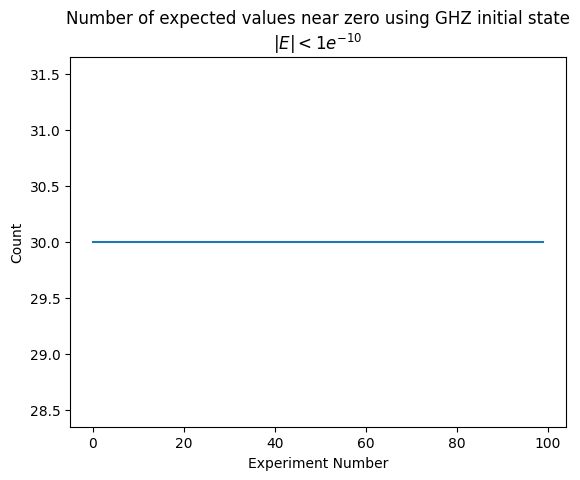

In [107]:
###
### Plot the number of times the expected values of any of the observables are near zero using various initial states.
### This is to show how often a near-zero expected value occurs.
###

names, obs = zip(*[
    # Agent 1 observations
    ## Z
    ('Z @ I @ I @ I', kron(Z, I, I, I)),
    ('I @ Z @ I @ I', kron(I, Z, I, I)),
    ('Z @ Z @ I @ I', kron(Z, Z, I, I)),
    ## X
    ('X @ I @ I @ I', kron(X, I, I, I)),
    ('I @ X @ I @ I', kron(I, X, I, I)),
    ('X @ X @ I @ I', kron(X, X, I, I)),
    ## Y
    ('Y @ I @ I @ I', kron(Y, I, I, I)),
    ('I @ Y @ I @ I', kron(I, Y, I, I)),
    ('Y @ Y @ I @ I', kron(Y, Y, I, I)),
    ## Z*
    ('Z @ X @ I @ I', kron(Z, X, I, I)),
    ('Z @ Y @ I @ I', kron(Z, Y, I, I)),
    ## X*
    ('X @ Y @ I @ I', kron(X, Y, I, I)),
    ('X @ Z @ I @ I', kron(X, Z, I, I)),
    ## Y*
    ('Y @ X @ I @ I', kron(Y, X, I, I)),
    ('Y @ Z @ I @ I', kron(Y, Z, I, I)),
    # ----
    # Agent 2 observations
    ## Z
    ('I @ I @ Z @ I', kron(I, I, Z, I)),
    ('I @ I @ I @ Z', kron(I, I, I, Z)),
    ('I @ I @ Z @ Z', kron(I, I, Z, Z)),
    ## X
    ('I @ I @ X @ I', kron(I, I, X, I)),
    ('I @ I @ I @ X', kron(I, I, I, X)),
    ('I @ I @ X @ X', kron(I, I, X, X)),
    ## Y
    ('I @ I @ Y @ I', kron(I, I, Y, I)),
    ('I @ I @ I @ Y', kron(I, I, I, Y)),
    ('I @ I @ Y @ Y', kron(I, I, Y, Y)),
    ## Z*
    ('I @ I @ Z @ X', kron(I, I, Z, X)),
    ('I @ I @ Z @ Y', kron(I, I, Z, Y)),
    ## X*
    ('I @ I @ X @ Y', kron(I, I, X, Y)),
    ('I @ I @ X @ Z', kron(I, I, X, Z)),
    ## Y*
    ('I @ I @ Y @ X', kron(I, I, Y, X)),
    ('I @ I @ Y @ Z', kron(I, I, Y, Z)),
])
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 2)

n_agents = 2
d_qubits = 2
n_layers = 5

circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

weight_shapes = circuit.weight_shapes


history = cl.defaultdict(list)
for i in range(100):

    agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
    agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

    # print(qml.draw(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs))


    # System unitary (all agents).
    U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)


    # GHZ initial state.
    B = bell(src=0, tgt=2, bellstate=0, nwires=4) @ bell(src=1, tgt=3, bellstate=0, nwires=4) # Phi+ on [0,2] and [1,3]
    M = (U @ B) @ ket(0,0,0,0)

    # # Zero initial state.
    # M = U @ ket(0,0,0,0)

    # Expected value of observables w.r.t combined unitary M.
    E = expectedValueOfObservable(M, obs)
    E = E.flatten()

    n_near_zero = np.count_nonzero(np.abs(E) < 1e-10)
    
    history['n_near_zero'].append(n_near_zero)

plt.plot(history['n_near_zero'])
plt.title('Number of expected values near zero using GHZ initial state\n$|E| < 1e^{-10}$')
plt.xlabel('Experiment Number')
plt.ylabel('Count')

### 3 Agents

In [240]:
n_agents = 3
d_qubits = 2
n_layers = 1

circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

weight_shapes = circuit.weight_shapes

agents_var_thetas = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_var_thetas'])
agents_enc_inputs = np.random.uniform(0, 2*np.pi, size=weight_shapes['agents_enc_inputs'])

print(qml.draw(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs))


# System unitary (all agents).
U = qml.matrix(circuit, wire_order=circuit.wires)(agents_var_thetas, agents_enc_inputs)

0: ─╭VariationalEncodingPQC─┤  
1: ─╰VariationalEncodingPQC─┤  
2: ─╭VariationalEncodingPQC─┤  
3: ─╰VariationalEncodingPQC─┤  
4: ─╭VariationalEncodingPQC─┤  
5: ─╰VariationalEncodingPQC─┤  


In [241]:
obs = [
    kron(Z, I, I, I, I, I),
    kron(I, Z, I, I, I, I),
    kron(Z, Z, I, I, I, I),
    kron(I, I, Z, I, I, I),
    kron(I, I, I, Z, I, I),
    kron(I, I, Z, Z, I, I),
    kron(I, I, I, I, Z, I),
    kron(I, I, I, I, I, Z),
    kron(I, I, I, I, Z, Z),
    ]
n_obs = len(obs)
n_obs_per_agent = int(n_obs / 3)

In [243]:
B = ghz(src=0, tgt=[2,4], bellstate=3, nwires=6) @ ghz(src=1, tgt=[3,5], bellstate=3, nwires=6)

M = (U @ B) @ ket(0,0,0,0,0,0)

# Expected value of observables w.r.t combined unitary M.
E = expectedValueOfObservable(M, obs)

# Difference between agent observables (maximum difference between agents 0,1 and 0,2).
diffs = np.array([max(E[i]-E[i+n_obs_per_agent], E[i]-E[i+2*n_obs_per_agent]) for i in range(n_obs_per_agent)])

E, diffs

(array([[[ 6.93889390e-17+0.j]],
 
        [[-5.55111512e-17+0.j]],
 
        [[-5.55111512e-17+0.j]],
 
        [[-1.38777878e-17+0.j]],
 
        [[-6.93889390e-17+0.j]],
 
        [[-1.38777878e-17+0.j]],
 
        [[-4.16333634e-17+0.j]],
 
        [[-5.55111512e-17+0.j]],
 
        [[ 1.04083409e-17+0.j]]]),
 array([[[ 1.11022302e-16+0.j]],
 
        [[ 1.38777878e-17+0.j]],
 
        [[-4.16333634e-17+0.j]]]))

## Simulations

In [92]:
n_actions = 3
n_agents = 3
d_qubits = 2
n_layers = 5
shape_obs = (n_agents, n_actions,)

observables = lambda wires: GroupedObservables(wires=wires, n_groups=n_agents, d_qubits=d_qubits, func=lambda wires: TensorObservables3(PauliObservables(wires=wires)))

initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
# initial_state = None
circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    observables=observables,
    initial_state=initial_state,
    )

qnode = circuit.qnode(device='default.qubit')

weight_shapes = circuit.weight_shapes

def run_batch(chunk_size):
    agents_var_thetas = np.random.uniform(0, np.pi, size=(chunk_size, *weight_shapes['agents_var_thetas']))
    agents_enc_inputs = np.random.uniform(0, np.pi, size=(chunk_size, *weight_shapes['agents_enc_inputs']))

    meas = qnode(
        agents_var_thetas=agents_var_thetas,
        agents_enc_inputs=agents_enc_inputs,
    )
    meas = np.asarray(meas).T # Reshape so batch dimension is first.
    meas = meas.reshape((-1, *shape_obs)) # Reshape to batched version of observation shape.
    return meas

func = lambda chunk_size: run_batch(chunk_size)

x = batched_experiment(
    func=func,
    repetitions=100,
    batch_size=32,
    )

In [93]:
# Check if all expected values are near zero.
print(f"{np.all(np.abs(x) < 1e-6)=}")

# Check if all expected values are close to each other.
print(f"{np.all(np.isclose(x, x[0][0]))=}")

# Count number of expected values that are near zero.
print(f"{np.count_nonzero(np.abs(x) < 1e-10)=}")

np.all(np.abs(x) < 1e-6)=True
np.all(np.isclose(x, x[0][0]))=True
np.count_nonzero(np.abs(x) < 1e-10)=900


In [94]:
x[0]

array([[ 8.32667268e-16,  1.94289029e-16,  4.44089210e-16],
       [ 3.33066907e-16,  1.11022302e-16, -5.55111512e-17],
       [-5.55111512e-17,  3.33066907e-16,  2.77555756e-16]])